In [2]:
import os
import operator
from dotenv import load_dotenv
from typing import Annotated, List, Optional
from typing_extensions import TypedDict

from pydantic import BaseModel, Field
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display, Markdown
from langchain_tavily import TavilySearch
import markdown2

In [3]:
load_dotenv()

groq_api_key = os.getenv("GROQ_API_KEY")
tavily_api_key = os.getenv("TAVILY_API_KEY")

In [4]:
llm = init_chat_model("groq:llama-3.3-70b-versatile")

tavily_tool = TavilySearch(max_results=3)

In [5]:
class Section(BaseModel):
    name: str = Field(description="Name for this section of the report.")
    description: str = Field(description="A brief overview of the main topics and concepts to be covered in this section.")

class Sections(BaseModel):
    sections: List[Section] = Field(description="The sections of the report.")


class Critique(BaseModel):
    revision_required: bool = Field(description="Whether the section requires revision.")
    feedback: str = Field(description="Constructive feedback for the writer on how to improve the section.")

class ReportState(TypedDict):
    topic: str
    sections: List[Section]
    current_section_index: int
    current_research_data: str
    draft_content: str
    feedback: Optional[str]
    revision_count: int
    completed_sections: Annotated[list, operator.add]
    final_report: str
    html_report_path: Optional[str] 


In [6]:
def orchestrator(state: ReportState):
    """Orchestrator: Creates a plan (sections) for the report."""
    print("--- RUNNING ORCHESTRATOR ---")
    planner = llm.with_structured_output(Sections)
    report_sections = planner.invoke([
        SystemMessage(content="Create a detailed and comprehensive plan for a report."),
        HumanMessage(content=f"The report topic is: {state['topic']}"),
    ])
    return {"sections": report_sections.sections}



In [7]:
def researcher(state: ReportState):
    """Researcher: Conducts a web search for the current section."""
    print("--- RUNNING RESEARCHER ---")
    current_index = state['current_section_index']
    current_section = state['sections'][current_index]
    print(f"-> Researching section: {current_section.name}")
    query = f"in-depth information on: {state['topic']} - {current_section.name}: {current_section.description}"
    search_result = tavily_tool.invoke(query)
    return {"current_research_data": search_result, "revision_count": 0}

In [8]:
def writer(state: ReportState):
    """Writer: Writes the current section, incorporating feedback if available."""
    print("--- RUNNING WRITER ---")
    current_index = state['current_section_index']
    current_section = state['sections'][current_index]
    research_data = state['current_research_data']
    feedback = state.get('feedback')

    count = state.get("revision_count", 0)

    prompt_addition = ""
    if feedback:
        print(f"-> Revising section (Attempt {count + 1}) based on feedback: {feedback}")
        prompt_addition = f"""
        IMPORTANT: You MUST revise the section based on the following feedback. 
        Prioritize these instructions over all other rules.
        REVISION FEEDBACK: {feedback}
        """
    else:
        print(f"-> Writing new draft for section: {current_section.name}")

    writer_prompt = f"""
    Write the following section in detail, using the provided research findings.
    Write only the section content, without a title and without any preamble. Use Markdown formatting.
    {prompt_addition}
    SECTION NAME: {current_section.name}
    SECTION DESCRIPTION: {current_section.description}
    RESEARCH FINDINGS TO USE:
    {research_data}
    """
    section_content = llm.invoke([
        SystemMessage(content="You are an expert report writer."),
        HumanMessage(content=writer_prompt),
    ]).content
    return {"draft_content": section_content, "revision_count": count + 1}

In [9]:
def critic(state: ReportState):
    """Critic: Reviews the draft and decides if revision is needed."""
    print("--- RUNNING CRITIC ---")
    draft = state['draft_content']
    critic_llm = llm.with_structured_output(Critique)
    
    critique_prompt = f"""
    You are an expert editor. Please review the following draft section.
    Evaluate it for clarity, accuracy, and depth.
    If the section is generally good but could be slightly better, approve it. 
    Only request a revision if there are significant errors or omissions.
    Your feedback must be concrete and actionable.

    DRAFT:
    {draft}
    """
    review: Critique = critic_llm.invoke([
        SystemMessage(content="You are an expert editor and critic."),
        HumanMessage(content=critique_prompt),
    ])

    print(f"-> Critic's decision: Revision required? {review.revision_required}")
    if review.revision_required:
        return {"feedback": review.feedback}
    else:
        return {"feedback": None}


In [10]:
def section_collector(state: ReportState):
    """Collector: Adds the approved draft to the completed sections list."""
    print("--- RUNNING COLLECTOR ---")
    current_index = state['current_section_index']
    current_section = state['sections'][current_index]
    draft_content = state['draft_content']
    
    full_section = f"## {current_section.name}\n\n{draft_content}"
    
    next_index = current_index + 1
    return {"completed_sections": [full_section], "current_section_index": next_index}


In [11]:
def synthesizer(state: ReportState):
    """Synthesizer: Combines all completed sections into the final report."""
    print("--- RUNNING SYNTHESIZER ---")
    final_report = "\n\n---\n\n".join(state["completed_sections"])
    return {"final_report": final_report}


In [12]:
MAX_REVISIONS = 3

def should_loop_for_revision(state: ReportState):
    """Decides whether to loop back to the writer or collect the section."""
    print("--- CHECKING REVISION STATUS ---")
    feedback = state.get("feedback")
    count = state.get("revision_count", 0)

    if feedback and count < MAX_REVISIONS:
        print(f"-> Revision required (Attempt {count}). Looping back to writer.")
        return "writer"  
    else:
        if count >= MAX_REVISIONS:
            print(f"-> Max revisions of {MAX_REVISIONS} reached. Accepting current draft.")
        else:
            print("-> Draft approved by critic. Moving on.")
        return "section_collector"
    


def should_continue_or_synthesize(state: ReportState):
    if state['current_section_index'] >= len(state['sections']):
        return "synthesizer" 
    else:
        return "researcher" 

In [13]:
def html_converter(state: ReportState):
    """Converts the final markdown report to a styled HTML file."""
    print("--- RUNNING HTML CONVERTER ---")
    
    # Get the final report content from the state
    markdown_report = state.get("final_report")
    if not markdown_report:
        return {}

    css_style = """
    <style>
        body {
            font-family: -apple-system, BlinkMacSystemFont, "Segoe UI", Roboto, Helvetica, Arial, sans-serif;
            line-height: 1.6;
            color: #333;
            max-width: 800px;
            margin: 40px auto;
            padding: 20px;
            background-color: #f9f9f9;
        }
        h1, h2, h3 {
            color: #2c3e50;
            border-bottom: 2px solid #ecf0f1;
            padding-bottom: 10px;
        }
        h1 {
            font-size: 2.5em;
        }
        h2 {
            font-size: 2em;
        }
        p {
            margin-bottom: 1em;
        }
        code {
            background-color: #ecf0f1;
            padding: 2px 5px;
            border-radius: 4px;
        }
        pre {
            background-color: #2c3e50;
            color: #f8f8f2;
            padding: 15px;
            border-radius: 5px;
            overflow-x: auto;
        }
        blockquote {
            border-left: 4px solid #3498db;
            padding-left: 15px;
            color: #555;
            font-style: italic;
        }
        table {
            width: 100%;
            border-collapse: collapse;
            margin-bottom: 1em;
        }
        th, td {
            border: 1px solid #ddd;
            padding: 8px;
            text-align: left;
        }
        th {
            background-color: #f2f2f2;
        }
    </style>
    """

    html_body = markdown2.markdown(markdown_report, extras=["tables", "fenced-code-blocks", "cuddled-lists"])

    report_title = state.get("topic", "AI Generated Report")

    full_html = f"""
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-g">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>{report_title}</title>
        {css_style}
    </head>
    <body>
        <h1>{report_title}</h1>
        {html_body}
    </body>
    </html>
    """

    file_path = "report.html"
    with open(file_path, "w", encoding="utf-8") as f:
        f.write(full_html)
    
    print(f"-> Report successfully saved to {file_path}")

    return {"html_report_path": file_path}

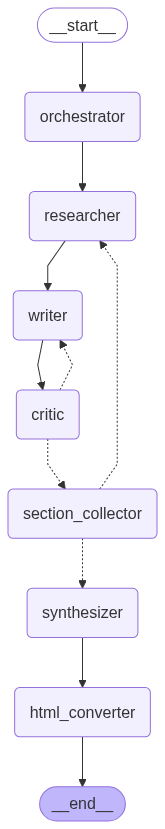

In [14]:
workflow = StateGraph(ReportState)

workflow.add_node("orchestrator", orchestrator)
workflow.add_node("researcher", researcher)
workflow.add_node("writer", writer)
workflow.add_node("critic", critic)
workflow.add_node("section_collector", section_collector)
workflow.add_node("synthesizer", synthesizer)
workflow.add_node("html_converter", html_converter) 


workflow.add_edge(START, "orchestrator")
workflow.add_edge("orchestrator", "researcher")
workflow.add_edge("researcher", "writer")
workflow.add_edge("writer", "critic")

workflow.add_conditional_edges(
    "critic",
    should_loop_for_revision,
    {"writer": "writer", "section_collector": "section_collector"}
)

workflow.add_conditional_edges(
    "section_collector",
    should_continue_or_synthesize,
    {"researcher": "researcher", "synthesizer": "synthesizer"}
)


workflow.add_edge("synthesizer", "html_converter")
workflow.add_edge("html_converter", END)

app = workflow.compile()

display(Image(app.get_graph().draw_mermaid_png()))

In [16]:
topic = "The career of Stephen Curry and his impact on the NBA"
initial_state = {
    "topic": topic,
    "current_section_index": 0,
    "completed_sections": []
}
final_state = app.invoke(initial_state, config={"recursion_limit": 100})

Markdown(final_state["final_report"])

--- RUNNING ORCHESTRATOR ---
--- RUNNING RESEARCHER ---
-> Researching section: Introduction
--- RUNNING WRITER ---
-> Writing new draft for section: Introduction
--- RUNNING CRITIC ---
-> Critic's decision: Revision required? False
--- CHECKING REVISION STATUS ---
-> Draft approved by critic. Moving on.
--- RUNNING COLLECTOR ---
--- RUNNING RESEARCHER ---
-> Researching section: Early Life and College Career
--- RUNNING WRITER ---
-> Writing new draft for section: Early Life and College Career
--- RUNNING CRITIC ---
-> Critic's decision: Revision required? False
--- CHECKING REVISION STATUS ---
-> Draft approved by critic. Moving on.
--- RUNNING COLLECTOR ---
--- RUNNING RESEARCHER ---
-> Researching section: Professional Career
--- RUNNING WRITER ---
-> Writing new draft for section: Professional Career
--- RUNNING CRITIC ---
-> Critic's decision: Revision required? False
--- CHECKING REVISION STATUS ---
-> Draft approved by critic. Moving on.
--- RUNNING COLLECTOR ---
--- RUNNING RE

## Introduction

### Early Career and Rise to Prominence
Stephen Curry is a professional basketball player who has made a profound impact on the National Basketball Association (NBA). Born with a natural talent for shooting, Curry's journey to becoming one of the most iconic players in NBA history began during his college years. As a college junior in 2009, he led the nation with an average of 28.6 points per game, showcasing his incredible scoring ability. This impressive performance caught the attention of NBA scouts, leading to his selection by the Golden State Warriors with the seventh pick in the NBA draft.

### Professional Success and Accolades
Curry's professional career has been marked by numerous achievements and accolades. He has won four NBA championships with the Golden State Warriors, including a league-record 73 wins in the 2015-2016 season. In 2013-2014, Curry averaged career highs of 24.0 points and 8.5 assists per game, becoming the first player in Warriors franchise history to achieve this feat. He has also been named the NBA's Most Valuable Player (MVP) by unanimous vote, a testament to his exceptional skill and dominance on the court.

### Notable Performances and Records
Throughout his career, Curry has delivered several memorable performances, including a 34-point outing in Game 5 of the NBA Finals, which helped the Warriors secure their second championship in three years. He has also recorded his first career postseason triple-double, with 32 points, 11 assists, and 10 rebounds in Game 2 of the 2017 NBA Finals against the Cleveland Cavaliers. Additionally, Curry has been instrumental in the Warriors' record-breaking 70-win season, scoring 27 points in a 112-101 win over the San Antonio Spurs.

### Legacy and Impact on the NBA
Stephen Curry's impact on the NBA extends beyond his impressive statistics and accolades. He has revolutionized the way teams approach the game, with his incredible shooting range and ability to score from anywhere on the court. Curry's influence has also been felt off the court, with his philanthropic efforts and commitment to social justice initiatives making him a respected figure in the basketball community. As one of the most dominant players of his generation, Curry continues to inspire and influence a new wave of basketball talent, cementing his legacy as one of the all-time greats in NBA history.

---

## Early Life and College Career

### Early Life
Stephen Curry was born on March 14, 1988, in Akron, Ohio, USA. His early life and upbringing played a significant role in shaping his future basketball career. Curry's family moved to Charlotte, North Carolina, where he spent most of his childhood. His father, Dell Curry, was a professional basketball player who played in the NBA for 16 seasons, which exposed Stephen to the game from a young age.

### High School Career
Curry attended Charlotte Christian School in North Carolina, where he developed his basketball skills. He was an outstanding player in high school, leading his team to three conference titles and one state appearance. Curry's impressive performance earned him all-conference, all-state, and all-American honors.

### College Career
After high school, Curry attended Davidson College in North Carolina, where he played college basketball for three years. During his time at Davidson, Curry led the nation in scoring with an average of 28.6 points per game as a junior in 2009. This impressive performance caught the attention of NBA scouts, and he was eventually selected by the Golden State Warriors with the seventh overall pick in the 2009 NBA draft. Curry's college career was marked by numerous awards and accolades, including the Naismith Trophy, the Wooden Award, and the consensus first-team All-American award.

### College Statistics and Achievements
*   Led the nation in scoring with an average of 28.6 points per game as a junior in 2009
*   Set the NCAA record for most three-pointers made in a season with 162
*   Named the consensus first-team All-American in 2009
*   Won the Naismith Trophy, the Wooden Award, and the consensus first-team All-American award in 2009

Overall, Curry's early life, high school, and college career laid the foundation for his successful NBA career. His hard work, dedication, and natural talent earned him numerous awards and accolades, ultimately leading to his selection by the Golden State Warriors in the 2009 NBA draft.

---

## Professional Career

### Rookie Season and Early Career
Stephen Curry was selected by the Golden State Warriors with the seventh overall pick in the 2009 NBA draft. After an impressive college career, where he led the nation with an average of 28.6 points per game as a junior in 2009, Curry was poised to make an immediate impact in the NBA. 

### Championships and Notable Achievements
Curry's professional career has been marked by numerous achievements, including four NBA championships with the Golden State Warriors. He won his first championship in the 2014-2015 season, where he made a then-record 286 three-pointers and led the Warriors to an NBA-best 67-15 record, earning him the league's Most Valuable Player (MVP) award. In the following season, Curry led the team to a league-record 73 wins, further solidifying his position as one of the top players in the league.

In the 2016-2017 season, Curry recorded his first career postseason triple-double with 32 points, 11 assists, and 10 rebounds in Game 2 of the NBA Finals against the Cleveland Cavaliers, helping the Warriors go up 2-0 in the series with a 132-113 win. He also won championships in the 2017-2018 and 2021-2022 seasons, with the latter being notable for Curry being named finals MVP after scoring 31.2 points per game during the six-game series win over the Boston Celtics.

### Career Statistics and Accolades
Throughout his career, Curry has consistently demonstrated his ability to score and facilitate, with career highs of 24.0 points and 8.5 assists per game in the 2013-2014 season. He became the first player in Warriors franchise history to average 24 points and eight assists in a single season, and the ninth player in NBA history to achieve this feat. Curry's impact on the game extends beyond his individual statistics, as he has been instrumental in the Warriors' success, leading the team to the best regular-season record in league history (73-9) in the 2015-2016 season.

### Legacy and Impact on the NBA
Stephen Curry's career has been marked by numerous records and accolades, including being the first person to be named MVP by unanimous vote in NBA history. His ability to shoot from beyond the arc has revolutionized the way teams approach the game, with many teams now incorporating more three-point shots into their offense. Curry's impact on the NBA extends beyond his on-court accomplishments, as he has become a role model and inspiration for many young players. His dedication, work ethic, and passion for the game have made him a beloved figure in the basketball world, and his legacy will continue to be felt for years to come.

---

## Impact on the NBA

### Influence on Three-Point Shooting
The NBA has witnessed a significant increase in three-point shooting since Stephen Curry's rise to prominence. Curry's unprecedented ability to make shots from beyond the arc has encouraged teams to adopt a more perimeter-oriented offense. As a result, the league has seen a substantial surge in three-point attempts, with teams now relying more heavily on outside shooting to create scoring opportunities. Curry's remarkable shooting range and accuracy have raised the bar for shooters across the league, and his influence can be seen in the way teams now construct their rosters and design their offenses.

### Evolution of the Point Guard Position
Curry's playing style has also contributed to the evolution of the point guard position. Traditionally, point guards were expected to be pass-first players who focused on setting up their teammates for scoring opportunities. However, Curry's success as a scoring point guard has led to a shift in this paradigm. Many teams now look for point guards who can score from both inside and outside the arc, while still maintaining the ability to distribute the ball effectively. This change has led to the development of more versatile point guards who can play both on and off the ball, creating matchup problems for opposing teams.

### Statistical Evidence of Curry's Impact
The numbers bear out Curry's influence on the NBA. He has made at least one 3-pointer in 967 of his 1,010 career games, a staggering 95.7% rate that ranks first all-time among players who have played at least 1,000 games. Curry's ability to make shots from anywhere on the court has also led to a number of record-breaking performances, including the most three-pointers in an All-Star quarter, half, and game. These achievements have cemented Curry's status as one of the greatest shooters in NBA history and have inspired a new generation of players to focus on developing their outside shooting skills.

### Coaching and Team Strategy
The hiring of Steve Kerr as the Golden State Warriors' head coach in 2014 marked a turning point in Curry's career, as Kerr's offense emphasized outside shooting and ball movement. This approach allowed Curry to flourish, and his success has led to a proliferation of similar offenses across the league. Many teams now employ coaches who have experience with small-ball lineups and outside shooting, and the use of advanced analytics has become more widespread in an effort to optimize team performance. As a result, the NBA has become a more fast-paced, perimeter-oriented league, with an increased emphasis on shooting and scoring.

---

## Off-Court Impact

### Philanthropic Efforts
Stephen Curry's off-court impact is significant, with a strong focus on philanthropy. He has been involved in various charitable foundations and initiatives, aiming to inspire younger generations to pursue their passions. Through his charitable work, Curry has made a positive impact on his community and beyond. His mission is to create opportunities for young people to develop their skills and achieve their goals.

### Business Ventures
In addition to his philanthropic efforts, Curry has also ventured into business, launching his own media company. This company allows him to produce content and tell stories that align with his values and interests. Curry's business ventures have not only expanded his brand but also provided a platform for him to share his vision and inspire others.

### Social Activism
Curry is also committed to social activism, using his platform to raise awareness about important issues. He has been involved in various initiatives, including court revitalization efforts at his alma mater. Through his Curry Brand, powered by Under Armour, he has refurbished courts and launched community impact commitments. These efforts demonstrate Curry's dedication to giving back to his community and creating positive change.

### Community Impact
The impact of Curry's off-court efforts can be seen in the various communities he has touched. His court revitalization efforts, for example, have provided young people with access to safe and quality facilities to play basketball. His branded cross-community NFT project has also built a vibrant basketball community in the metaverse. Furthermore, his footwear line, Curry FloTro, has combined style, speed, and simplicity, making it accessible to a wide range of players.

### Legacy
Curry's off-court impact has significantly contributed to his legacy, extending beyond his achievements on the court. His philanthropic efforts, business ventures, and social activism have cemented his position as a role model and inspiration to many. As he continues to balance his life as a player and philanthropist, Curry's legacy is likely to endure, motivating future generations to pursue their passions and make a positive impact on their communities.

---

## Conclusion

### Summary of Achievements
Stephen Curry is a professional basketball player who has made a lasting impact on the NBA and beyond. Throughout his career, he has achieved numerous accolades, including being the first person to be named MVP by unanimous vote in NBA history. Curry has won four NBA championships with the Golden State Warriors and has led the team to a league-record 73 wins in a single season.

### Career Highlights
Curry's impressive career statistics include averaging career highs of 24.0 points and 8.5 assists per game in the 2013-2014 season, making him the first player in Warriors franchise history to achieve this feat. He has also recorded his first career postseason triple-double with 32 points, 11 assists, and 10 rebounds in Game 2 of the 2017 NBA Finals against the Cleveland Cavaliers.

### Legacy
Curry's impact on the NBA extends beyond his on-court achievements. He has inspired a new generation of players with his unique playing style and has helped to popularize the game globally. His success has also paved the way for other players to follow in his footsteps, and his legacy continues to be felt throughout the league.

### Conclusion
In conclusion, Stephen Curry's career has been marked by numerous achievements and accolades, cementing his status as one of the greatest players in NBA history. His lasting impact on the league and beyond is a testament to his hard work, dedication, and passion for the game. As he continues to play and inspire, his legacy will only continue to grow, leaving a lasting impression on the world of basketball and beyond.